# 題目:表情辨識

## 組員介紹
### 108701005 應數一 連浩宇
### 108701017 應數一 張克齊

## 專案發想
俗話說的好:女人心，海底針。女生的心情複雜程度實在難以用肉眼辨識，因此我們想藉由CNN深度學習協助我們讀懂他人的心情。

## 專案流程:
### (1).資料蒐集:
主要是在蒐集各大社群的圖片及google圖片作為資料庫。
### (2).資料整理:
後來發 現有FER2013的csv資料可用，所以我們以FER2013的資料來做訓練。
### (3)結論及檢查

## 專案實際排程及分工
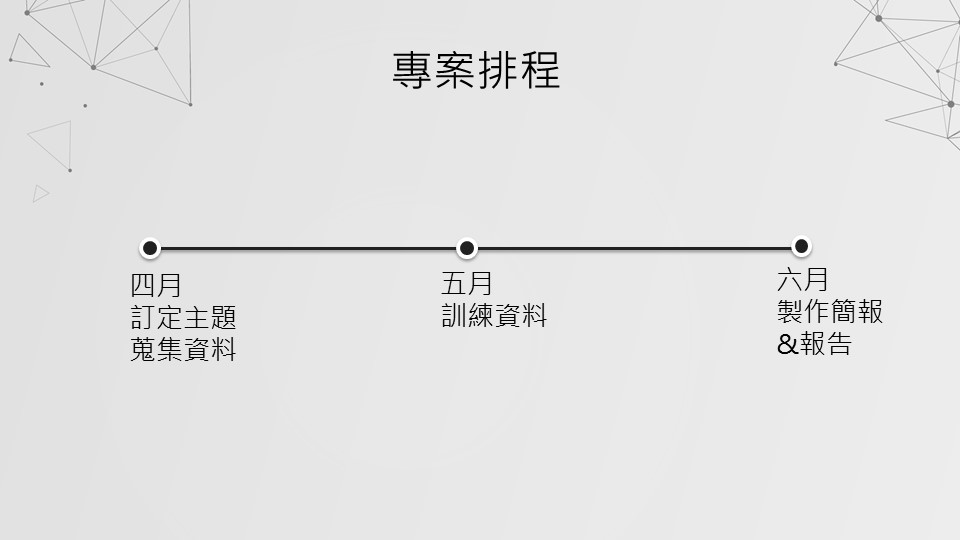
主要我們這組只有兩個人，所以包括蒐集資料，實作都是兩人共同完成。

## 資料來源
主要訓練資料都是來自https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data


## 經過多次測試，無法解決原程式問題，所以新參考了多個FER2013的作品後，改寫之。

### 授權
If you use this dataset in your research work, please cite

"Challenges in Representation Learning: A report on three machine learning
contests." I Goodfellow, D Erhan, PL Carrier, A Courville, M Mirza, B
Hamner, W Cukierski, Y Tang, DH Lee, Y Zhou, C Ramaiah, F Feng, R Li,
X Wang, D Athanasakis, J Shawe-Taylor, M Milakov, J Park, R Ionescu,
M Popescu, C Grozea, J Bergstra, J Xie, L Romaszko, B Xu, Z Chuang, and
Y. Bengio. arXiv 2013.

See fer2013.bib for a bibtex entry.
https://www.kaggle.com/ashishpatel26/tutorial-facial-expression-classification-keras

### 其餘參考網站
https://www.kaggle.com/milan400/fer2013-facial-expression-detection
https://medium.com/%E6%89%8B%E5%AF%AB%E7%AD%86%E8%A8%98/%E4%BD%BF%E7%94%A8-tensorflow-%E4%BA%86%E8%A7%A3%E9%81%8E%E6%93%AC%E5%90%88%E8%88%87%E6%AC%A0%E6%93%AC%E5%90%88-a75a26cc87e0
https://blog.csdn.net/mike112223/article/details/75339383

In [18]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import keras

from keras.utils import np_utils

from keras import backend as K

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD,RMSprop,adam, Adadelta
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
import pandas as pd



In [2]:
# %% [code]
import os
for dirname, _, filenames in os.walk('../input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# %% [code]
# get the data
filname = "D:\\Downloads\\31050_39603_compressed_fer2013.csv (1)\\fer2013.csv"
label_map = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
names=['emotion','pixels','usage']
df=pd.read_csv("D:\\Downloads\\31050_39603_compressed_fer2013.csv (1)\\fer2013.csv",names=names, na_filter=False)
im=df['pixels']
df.head(10)

# %% [code]
a = df['emotion']
idx = pd.Index(a)
count = idx.value_counts()
print(count)

# %% [code] {"colab":{},"colab_type":"code","id":"UEcO-PMyUkhO"}
from keras.models import Sequential
from keras.layers import Dense , Activation , Dropout ,Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.metrics import categorical_accuracy
from keras.models import model_from_json
from keras.callbacks import ModelCheckpoint
from keras.optimizers import *
from keras.layers.normalization import BatchNormalization




3          8989
6          6198
4          6077
2          5121
0          4953
5          4002
1           547
emotion       1
Name: emotion, dtype: int64


In [3]:
# %% [code]
def getData(filname):
    # images are 48x48
    # N = 35887
    Y = []
    X = []
    first = True
    for line in open(filname):
        #This condition skips the first condition
        if first:
            first = False
        else:
            row = line.split(',')
            Y.append(int(row[0]))
            X.append([int(p) for p in row[1].split()])

    #X, Y = np.array(X) / 255.0, np.array(Y)
    X, Y = np.array(X)/255.0 , np.array(Y)
    return X, Y

# %% [code]
X, Y = getData(filname)
num_class = len(set(Y))
print(num_class)

# %% [markdown]
# Preprocess Image to detect only face

# %% [code]
X.shape

# %% [code]
# keras with tensorflow backend
N,D = X.shape
X = X.reshape(N, 48, 48, 1)





7


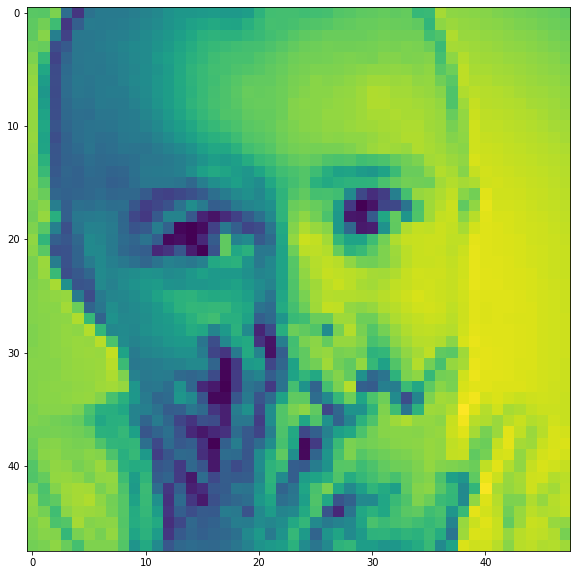

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 1, 1, 512)         20023232  
_________________________________________________________________
flatten_2 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 3591      
Total params: 20,026,823
Trainable params: 20,026,823
Non-trainable params: 0
_________________________________________________________________


In [5]:
# %% [markdown]
# **Split Train Test data**

# %% [code]
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
y_train = (np.arange(num_class) == y_train[:, None]).astype(np.float32)
y_test = (np.arange(num_class) == y_test[:, None]).astype(np.float32)

# %% [code]
img = X_train[780].reshape(48,48)
plt.imshow(img, interpolation='nearest')
plt.show()

# %% [code]
from keras.applications import VGG19
#Load the VGG model
vgg_conv = VGG19(weights=None, include_top=False, input_shape=(48, 48,1))

# %% [code]
def vgg_custom():
    model = Sequential()
    #add vgg conv model
    model.add(vgg_conv)
    
    #add new layers
    model.add(Flatten())
    model.add(Dense(7,  kernel_initializer='normal'))
    #model.compile(loss='mean_squared_error', optimizer=adam())
    model.compile(loss='mean_squared_error', optimizer=RMSprop())
    
    return model

# %% [code] {"colab":{"base_uri":"https://localhost:8080/","height":734},"colab_type":"code","id":"Gjmj9Cz3VT1b","outputId":"2ffb75fb-f6eb-4f49-8afe-68e86641b5f4"}
model = vgg_custom()
model.summary()

# %% [code] {"colab":{},"colab_type":"code","id":"8CNczAIPVhDy"}
from keras import callbacks
filename='model_train_new.csv'
filepath="Best-weights-my_model-{epoch:03d}-{loss:.4f}-{acc:.4f}.hdf5"

csv_log=callbacks.CSVLogger(filename, separator=',', append=False)
checkpoint = callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [csv_log,checkpoint]
callbacks_list = [csv_log]

# %% [markdown]
# Image Augmentation

# %% [code]
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")




Epoch 1/20
3588/3588 [==============================] - 1490s 415ms/step - loss: 5.7612 - val_loss: 0.1187
Epoch 2/20
3588/3588 [==============================] - 1454s 405ms/step - loss: 0.1185 - val_loss: 0.1187
Epoch 3/20
3588/3588 [==============================] - 1345s 375ms/step - loss: 0.1185 - val_loss: 0.1191
Epoch 4/20
3588/3588 [==============================] - 1344s 375ms/step - loss: 0.1185 - val_loss: 0.1185
Epoch 5/20
3588/3588 [==============================] - 1344s 375ms/step - loss: 0.1185 - val_loss: 0.1186
Epoch 6/20
3588/3588 [==============================] - 1346s 375ms/step - loss: 0.1185 - val_loss: 0.1194
Epoch 7/20
3588/3588 [==============================] - 1345s 375ms/step - loss: 0.1185 - val_loss: 0.1187
Epoch 8/20
3588/3588 [==============================] - 1344s 375ms/step - loss: 0.1185 - val_loss: 0.1185
Epoch 9/20
3588/3588 [==============================] - 1343s 374ms/step - loss: 0.1185 - val_loss: 0.1188
Epoch 10/20
3588/3588 [=============

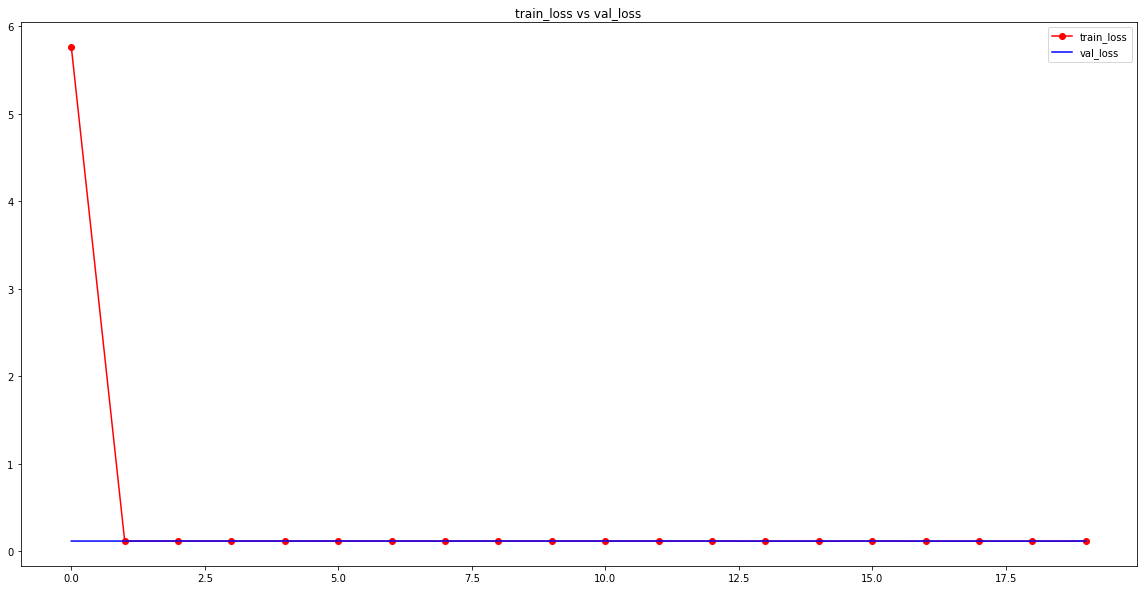

<Figure size 1440x720 with 0 Axes>

In [6]:
# %% [markdown]
# Define Batch Size and Epoch iteration

# %% [code]
BS =8
EPOCHS = 20

# %% [code]
len(X_train)

# %% [markdown]
# Fit augmentated Data into model

# %% [code] {"colab":{"base_uri":"https://localhost:8080/","height":1980},"colab_type":"code","id":"7s8Uy0G8WnTa","outputId":"a5ce06fa-576f-47b0-b6d8-da606e32fd7f"}
history = model.fit_generator(
    aug.flow(X_train, y_train, batch_size=BS),
    validation_data=(X_test, y_test),
    steps_per_epoch=len(X_train) // BS,
    epochs=EPOCHS, verbose=1,
    callbacks = callbacks_list 
    ,shuffle = True
    )

# %% [code] {"colab":{},"colab_type":"code","id":"tYAXlAm7WzSw"}
#Model Save
model.save_weights('model_weights.h5')
model.save('model_keras.h5')

# %% [code]
hist = history

# %% [code] {"colab":{"base_uri":"https://localhost:8080/","height":581},"colab_type":"code","id":"Enxigu7LYX5e","outputId":"05f9582a-efd7-41ee-a2ae-0443a9b13440"}
# visualizing losses and accuracy
# %matplotlib inline

train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
#train_acc=hist.history['acc']
#val_acc=hist.history['val_acc']

epochs = range(len(val_loss))

plt.plot(epochs,train_loss,'r-o', label='train_loss')
plt.plot(epochs,val_loss,'b', label='val_loss')
plt.title('train_loss vs val_loss')
#plt.plot(epochs,train_loss,'r-o', label='train_acc')
#plt.plot(epochs,val_loss,'b', label='val_acc')
#plt.title('train_acc vs val_acc')
plt.title('train_loss vs val_loss')
plt.legend()
plt.figure()
#plt.savefig('train_test_acc.png')
plt.savefig('train_test.png')

In [8]:
# %% [code]
print(train_loss)

# %% [code]
print('accuracy: {} loss: {}'.format((1-train_loss[-1])*100,(train_loss[-1])*100))

# %% [code]
print(val_loss)

# %% [code]
print('accuracy: {} loss: {}'.format((1-val_loss[-1])*100,(val_loss[-1])*100))

# %% [code] {"colab":{"base_uri":"https://localhost:8080/","height":707},"colab_type":"code","id":"nvqxVr7qYbxX","outputId":"3554ef0e-d6b6-4956-ef8a-6ff78f88246c"}
# Evaluating the model
score = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss:', score)

test_image = X_test[0:1]
print (test_image.shape)

[5.761742623245827, 0.11846200254792216, 0.11847285701534416, 0.11849468679984626, 0.11853132154813964, 0.11848495121462363, 0.11850749705544807, 0.11849752920270402, 0.11850272610247257, 0.11850493146368594, 0.11848894820826456, 0.1185338493989638, 0.11847692715634053, 0.1184300962616324, 0.11854139419730658, 0.11847938771570964, 0.11855017592675728, 0.1184886044333203, 0.11847298025715239, 0.11849032750410393]
accuracy: 88.15096724958961 loss: 11.849032750410393
[0.11872611699097002, 0.11867243839766728, 0.11907474533466617, 0.11854095227640629, 0.11863822461121193, 0.11935773030583591, 0.118674751625449, 0.11851141167720004, 0.11877819549268452, 0.1187061218456094, 0.11864507194597032, 0.11895647850930774, 0.11880118576314132, 0.11835512904801651, 0.11841317552914357, 0.11884037857601722, 0.11832170862695174, 0.11824391528187637, 0.11823685637055814, 0.11870206248323444]
accuracy: 88.12979375167656 loss: 11.870206248323443
Test Loss: 0.11870206238981673
(1, 48, 48, 1)


In [9]:
#predict
y_pred = model.predict(X_test) 

In [10]:
print(model.predict(test_image))
print(model.predict_classes(test_image))
print(y_test[0:1])
res = model.predict_classes(X_test[9:18])
plt.figure(figsize=(10, 10))


[[0.08772621 0.04027865 0.14784373 0.24622998 0.18842435 0.11598007
  0.1594079 ]]
[3]
[[0. 0. 0. 1. 0. 0. 0.]]


<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

In [11]:
# %% [code]
from sklearn.metrics import confusion_matrix
results = model.predict_classes(X_test)
cm = confusion_matrix(np.where(y_test == 1)[1], results)
#cm = cm.astype(np.float) / cm.sum(axis=1)[:, np.newaxis]

In [12]:
# %% [markdown]
# Confusion Matrix

# %% [code]
import seaborn as sns

# %% [code]
label_mapdisgust = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# %% [code]
#Transform to df for easier plotting
cm_df = pd.DataFrame(cm, index = label_mapdisgust,
                     columns = label_mapdisgust
                    )


In [13]:
# %% [code]
final_cm = cm_df.drop('Disgust',axis=0)
final_cm = final_cm.drop('Disgust',axis=1)

# %% [code]
final_cm


,Anger,Fear,Happy,Sad,Surprise,Neutral
Anger,0,0,985,0,0,0
Fear,0,0,1043,0,0,0
Happy,0,0,1765,0,0,0
Sad,0,0,1210,0,0,0
Surprise,0,0,795,0,0,0
Neutral,0,0,1278,0,0,0


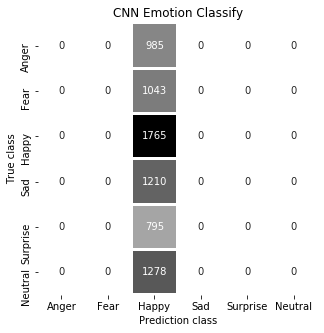

In [14]:
# %% [code]
plt.figure(figsize = (5,5))
sns.heatmap(final_cm, annot = True,cmap='Greys',cbar=False,linewidth=2,fmt='d')
plt.title('CNN Emotion Classify')
plt.ylabel('True class')
plt.xlabel('Prediction class')
plt.show()





In [15]:
# %% [markdown]
# ROC Curve

# %% [code]
from sklearn.metrics import roc_curve,auc
from itertools import cycle

# %% [code]
new_label = ['Anger', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
final_label = new_label
new_class = 6

# %% [code]
#ravel flatten the array into single vector
y_pred_ravel = y_pred.ravel()
lw = 2

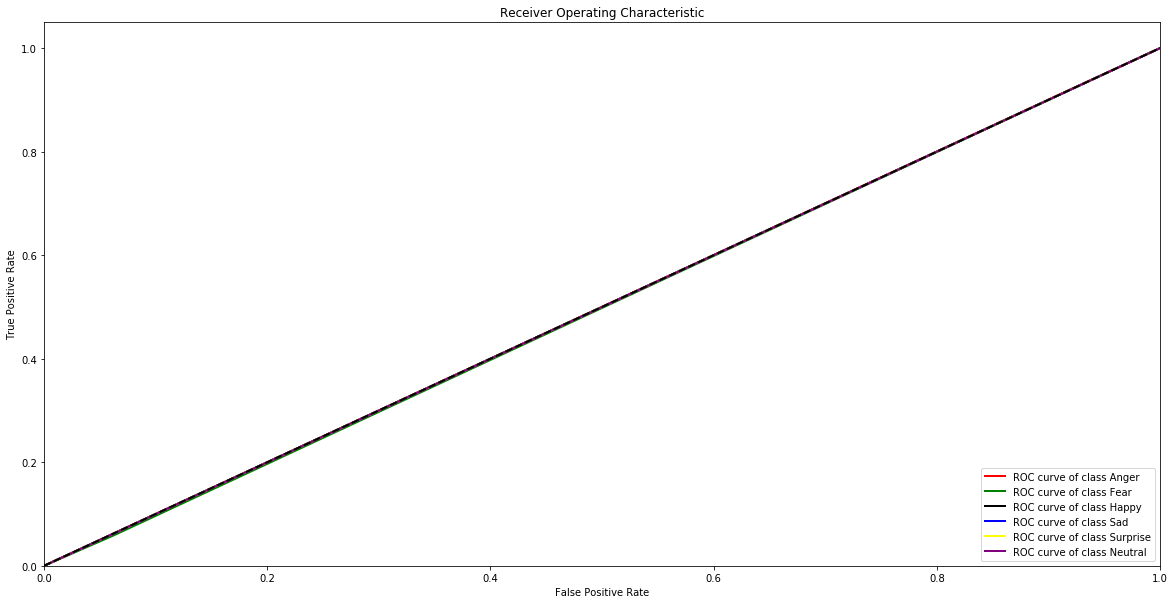

In [16]:
# %% [code]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(new_class):
    fpr[i], tpr[i], _ = roc_curve(y_test[:,i], y_pred[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
#colors = cycle(['red', 'green','black'])
colors = cycle(['red', 'green','black','blue', 'yellow','purple'])
for i, color in zip(range(new_class), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0}'''.format(final_label[i]))
    

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [26]:
def emotion_analysis(emotions):
    new_label = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
    y_pos = np.arange(len(new_label))
    plt.bar(y_pos, emotions, align='center', alpha=0.9)
    plt.tick_params(axis='x', which='both', pad=10,width=4,length=10)
    plt.xticks(y_pos, new_label)
    plt.ylabel('percentage')
    plt.title('emotion')
    
plt.show()

### 實作

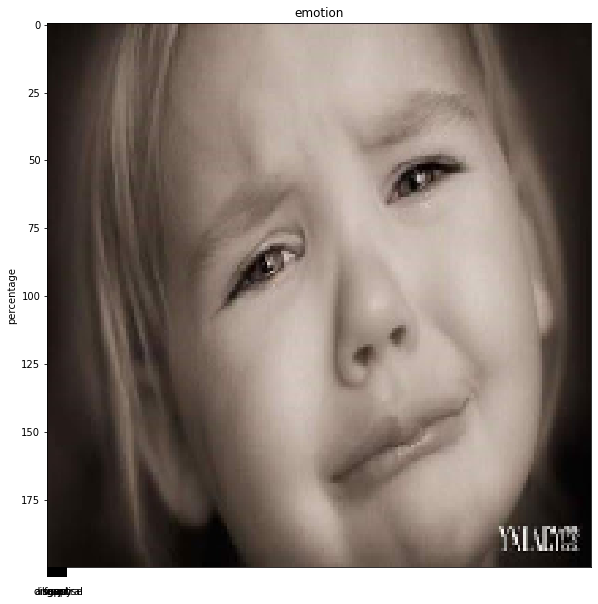

Expression Prediction: Sad


In [30]:
from skimage import io
img = image.load_img("D:\\Desktop\\photo\\sad.jpg", grayscale=True, target_size=(48, 48))
show_img=image.load_img("D:\\Desktop\\photo\\sad.jpg", grayscale=False, target_size=(200, 200))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = model.predict(x)
#print(custom[0])
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([48, 48]);

plt.gray()
plt.imshow(show_img)
plt.show()

m=0.000001
a=custom[0]
for i in range(0,len(a)):
    if a[i]>m:
        m=a[i]
        ind=i
        
print('Expression Prediction:',new_label[ind])

### 專案結論
在實作專案的過程中，我們理解了這次專案是非常縝密的，整個測試的結果可能因為一個參數設定不當而有巨大的影響，最後雖然有一定的準確率，但其實還有進步的空間，在之後我們也會繼續嘗試其他方式或調整參數以提高準確率，包括之前程式的overfitting的現象，至今我們也利用許多方式嘗試改善結果不甚精確。

### 心得
前面有一組的情緒辨識套用在影片上，他們使用的是GAN模型，與我們不太一樣，我們認為這是一個我們能夠嘗試的目標，也許之後可以試試不同的模型的應用。